<a href="https://colab.research.google.com/github/Fatehab/machine-learning/blob/main/Instagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Applying machine learning model to instagram dataset

Data Input

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.5 MB/s eta 0:00:00


In [ ]:
import os
os.environ['LC_CTYPE'] = 'en_US.UTF-8'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import string
import numpy as np
import spacy 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [ ]:
#Data Input
path ="/content/drive/MyDrive/smalldata/instagramcomment.csv"
df = pd.read_csv(path)
df

,Comments,Label
0,There are not enough vomit emoji's.,1
1,Creep,1
2,I genuinely can't like this post because becau...,0
3,This guy dresses like this because he thinks i...,1
4,He is a full on creep ??????,1
...,...,...
1220,"She is a queen stay away you hater, jerk",1
1221,@kylie.jenner_hate fucking jealous of her life...,1
1222,"The one that can, can and the one that doesn't...",0
1223,ooo....Fuck it's so fake bruh,1


DATA EXPLORATION

Number of rows and columns in the dataset: (1225, 2)
Summary statistics of numerical columns:
              Label
count  1225.000000
mean      0.421224
std       0.493957
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Comments  1225 non-null   object
 1   Label     1225 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 19.3+ KB
Information about the dataset:
 None
Missing values in each column:
 Comments    0
Label       0
dtype: int64
Distribution of labels:
 0    709
1    516
Name: Label, dtype: int64
Most frequent words in cyberbullying comments:
 a       189
you     180
the     138
to      110
and     110
dumb     95
is       92
fuck     77
I        74
of       73
dtype: int64
Most frequent words in non-cyberbullying comments:
 the     220
a

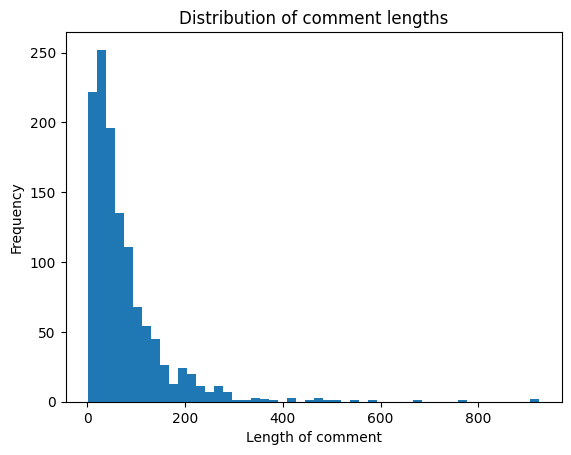

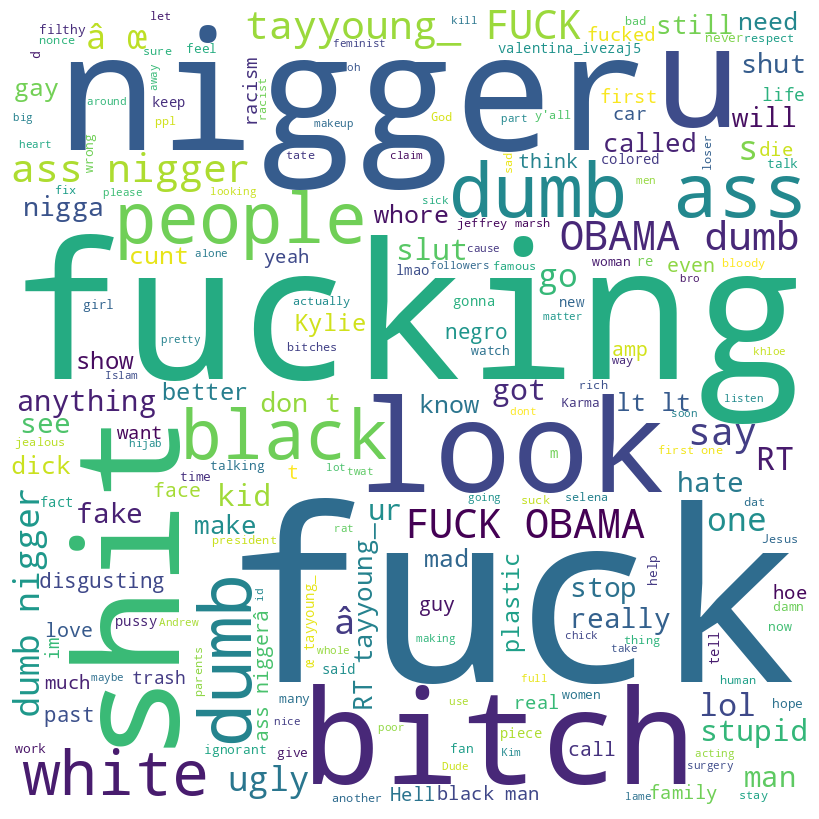

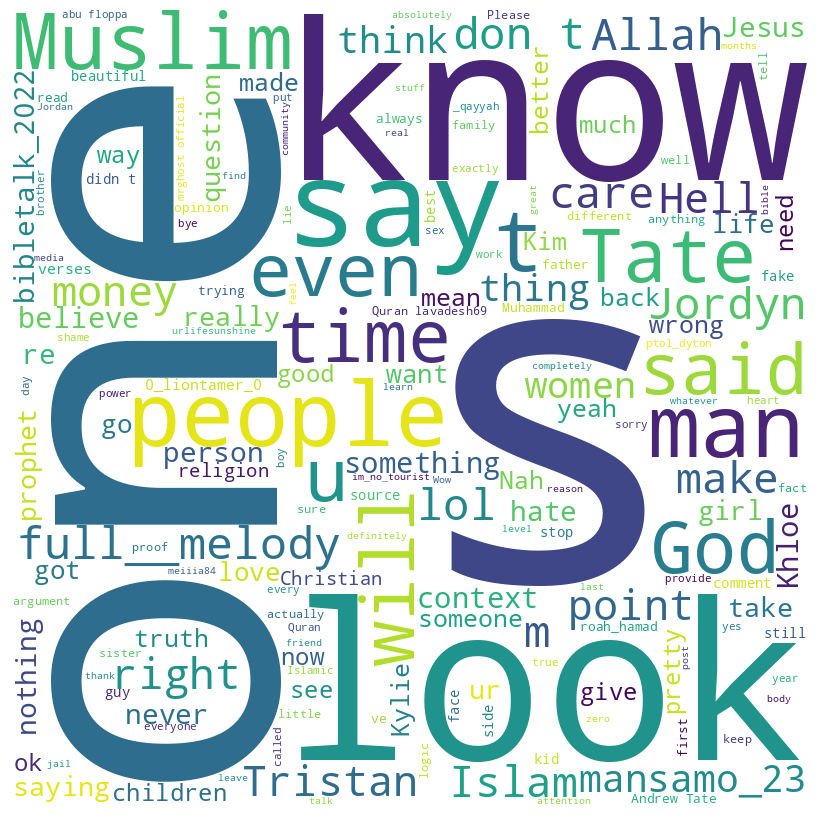

In [ ]:
# Data Exploration
print("Number of rows and columns in the dataset:", df.shape)
print("Summary statistics of numerical columns:\n", df.describe())
print("Information about the dataset:\n", df.info())

# Checking for missing values
print("Missing values in each column:\n", df.isnull().sum())

# Examining the distribution of the data
print("Distribution of labels:\n", df['Label'].value_counts())

# Identifying relationships between variables
cyberbullying_comments = df[df['Label'] == 1]['Comments']
non_cyberbullying_comments = df[df['Label'] == 0]['Comments']
print("Most frequent words in cyberbullying comments:\n", cyberbullying_comments.str.split(expand=True).stack().value_counts()[:10])
print("Most frequent words in non-cyberbullying comments:\n", non_cyberbullying_comments.str.split(expand=True).stack().value_counts()[:10])

# Visualizing the data
plt.hist(df['Comments'].str.len(), bins=50)
plt.title('Distribution of comment lengths')
plt.xlabel('Length of comment')
plt.ylabel('Frequency')
plt.show()

cyberbullying_wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = STOPWORDS, min_font_size = 10).generate(' '.join(cyberbullying_comments))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cyberbullying_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

non_cyberbullying_wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = STOPWORDS, min_font_size = 10).generate(' '.join(non_cyberbullying_comments))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(non_cyberbullying_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
# Count the number of occurrences of each label
label_counts = df['Label'].value_counts()

# Print the results
print(label_counts)

0    709
1    516
Name: Label, dtype: int64


Pre-processing

In [ ]:
#Converting dataset to lowercase letters
df['Comments'] = df['Comments'].apply(lambda x: " ".join(x.lower () for x in x.split()))
#Removing Puncuation from dataset
df['Comments'] = df['Comments'].str.replace('[^\w\s]','')

def removeSpecialCharacter(v):
    c = "".join([r for r in v if ('A' <= r <= 'Z') or ('a' <= r <= 'z') or (r == " ")])
    return c

df['Comments']= df['Comments'].apply(lambda x: removeSpecialCharacter (str(x)))
df['Comments'].replace('', np.nan, inplace=True)

df.dropna(subset=['Comments'], inplace=True)

#removing numbers from text
def remove_digits(txt):
    txt_nodigit = "".join([char for char in txt if not char.isdigit()])
    return txt_nodigit


df['Comments'] = df['Comments'].apply(lambda x: remove_digits(x))
df

<ipython-input-8-a75c6d755a60>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Comments'] = df['Comments'].str.replace('[^\w\s]','')


,Comments,Label
0,there are not enough vomit emojis,1
1,creep,1
2,i genuinely cant like this post because becaus...,0
3,this guy dresses like this because he thinks i...,1
4,he is a full on creep,1
...,...,...
1220,she is a queen stay away you hater jerk,1
1221,kyliejennerhate fucking jealous of her life co...,1
1222,the one that can can and the one that doesnt c...,0
1223,ooofuck its so fake bruh,1


Feature Extraction

In [ ]:
clf = CountVectorizer()
fb  =  clf.fit_transform(df['Comments'])

tf_transformer = TfidfTransformer(use_idf=True).fit(fb)
X_tf = tf_transformer.transform(fb)
X_tf

<1201x3292 sparse matrix of type '<class 'numpy.float64'>'
	with 14266 stored elements in Compressed Sparse Row format>

In [ ]:
#Splitting the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_tf, df['Label'], test_size=0.30, stratify=df['Label'], random_state=42)

Machine Learning Algorithms 

In [ ]:
#Support Vector Machine (SVM)
sv_clf = svm.SVC()
sv_clf.fit(X_train, Y_train)

SVC()

In [ ]:
#XGBoost
xg_clf = XGBClassifier()
xg_clf.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Performance Evaluation

In [ ]:
#Support vector machine
sv_pred = sv_clf.predict(X_test)
print('Classification Report for Support Vector Machine:\n',classification_report(Y_test, sv_pred))

Classification Report for Support Vector Machine:
               precision    recall  f1-score   support

           0       0.71      0.97      0.82       206
           1       0.92      0.46      0.62       155

    accuracy                           0.75       361
   macro avg       0.81      0.72      0.72       361
weighted avg       0.80      0.75      0.73       361



In [ ]:
# Predict labels for the training set
train_pred = sv_clf.predict(X_train)

# Print the classification report
print('Classification Report for Support Vector Machine (Training Set):\n', classification_report(Y_train, train_pred))

Classification Report for Support Vector Machine (Training Set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       479
           1       1.00      0.99      1.00       361

    accuracy                           1.00       840
   macro avg       1.00      1.00      1.00       840
weighted avg       1.00      1.00      1.00       840



Bert Model with XGBOOST

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report

# Load pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize text and generate BERT embeddings
X = df['Comments'].values
X_tokens = tokenizer.batch_encode_plus(X, padding=True, truncation=True, max_length=256, return_tensors='pt')
input_ids = X_tokens['input_ids']
attention_mask = X_tokens['attention_mask']
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)[0]
features = last_hidden_states[:,0,:].numpy()

# Split the data into train and test sets
labels = df['Label'].values
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train the XGBoost classifier on the BERT features
dtrain = xgb.DMatrix(X_train, label=Y_train)
params = {'objective': 'multi:softmax', 'num_class': len(np.unique(Y_train))}
xgb_classifier = xgb.train(params, dtrain)

# Evaluate the XGBoost classifier on the test set
dtest = xgb.DMatrix(X_test)
Y_test_pred = xgb_classifier.predict(dtest)
xgb_accuracy = np.mean(Y_test_pred == Y_test)
print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')

# Print out the classification report on the training set
dtrain_pred = xgb_classifier.predict(dtrain)
print(classification_report(Y_train, dtrain_pred))

# Print out the classification report on the testing set
Y_test_pred = xgb_classifier.predict(dtest)
print(classification_report(Y_test, Y_test_pred))



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XGBoost Accuracy: 0.7424
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       480
           1       1.00      1.00      1.00       360

    accuracy                           1.00       840
   macro avg       1.00      1.00      1.00       840
weighted avg       1.00      1.00      1.00       840

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       205
           1       0.73      0.63      0.68       156

    accuracy                           0.74       361
   macro avg       0.74      0.73      0.73       361
weighted avg       0.74      0.74      0.74       361



Testing XG Boost on its own 

In [ ]:
#XGBoost
xg_clf = XGBClassifier()
xg_clf.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
#XGBoost
xg_pred = xg_clf.predict(X_test)
print('Classification Report for XGBOOST (Testing Set):\n',classification_report(Y_test, xg_pred))

# Predict labels for the training set
train_pr = xg_clf.predict(X_train)

# Print the classification report
print('Classification Report for XGBoost (Training Set):\n', classification_report(Y_train, train_pr))

Classification Report for XGBOOST (Testing Set):
               precision    recall  f1-score   support

           0       0.76      0.87      0.81       205
           1       0.79      0.64      0.71       156

    accuracy                           0.77       361
   macro avg       0.77      0.75      0.76       361
weighted avg       0.77      0.77      0.77       361

Classification Report for XGBoost (Training Set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       480
           1       1.00      1.00      1.00       360

    accuracy                           1.00       840
   macro avg       1.00      1.00      1.00       840
weighted avg       1.00      1.00      1.00       840

